[Data fields]

funda_train.csv

1. store_id : 상점의 고유 아이디

2. card_id : 사용한 카드의 고유 아이디

3. card_company : 비식별화된 카드 회사

4. trasacted_date : 거래 날짜

5. transacted_time : 거래 시간( 시:분 )

6. installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )

7. region : 상점의 지역

8. type_of_business : 상점의 업종

9. amount : 거래액(단위는 원이 아닙니다)

카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 상점별 3개월 총 매출을 예측하는 것입니다

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv('funda_train.csv')
df_test  = pd.read_csv('submission.csv')

In [3]:
# 데이터 주작
# 환불(refund), 매출(sale) 컬럼 추가
df_train['refund'] = df_train['amount'].apply(lambda x:1 if x < 0 else 0)
df_train['sale'] =  df_train['amount'].apply(lambda x:1 if x >= 0 else 0)
# 년도별, 월별 맞춰줌
df_train['yyyy'] = df_train['transacted_date'].apply(lambda x: x[0:4])
df_train['mm'] = df_train['transacted_date'].apply(lambda x: x[5:7])
df_train['yyyymm'] = df_train['transacted_date'].apply(lambda x: x[0:4] + x[5:7])

In [4]:
df_train.dtypes

store_id              int64
card_id               int64
card_company         object
transacted_date      object
transacted_time      object
installment_term      int64
region               object
type_of_business     object
amount              float64
refund                int64
sale                  int64
yyyy                 object
mm                   object
yyyymm               object
dtype: object

In [5]:
df_train.shape

(6556613, 14)

In [6]:
# 결측치 확인
print((df_train.isnull()).sum(axis=0))
# 결측치 비율
print((df_train.isnull()).sum(axis=0) / df_train.shape[0])

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
refund                    0
sale                      0
yyyy                      0
mm                        0
yyyymm                    0
dtype: int64
store_id            0.000000
card_id             0.000000
card_company        0.000000
transacted_date     0.000000
transacted_time     0.000000
installment_term    0.000000
region              0.311558
type_of_business    0.602843
amount              0.000000
refund              0.000000
sale                0.000000
yyyy                0.000000
mm                  0.000000
yyyymm              0.000000
dtype: float64


In [7]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,refund,sale,yyyy,mm,yyyymm
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,0,1,2016,06,201606
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,0,1,2016,06,201606
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,0,1,2016,06,201606
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,0,1,2016,06,201606
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,0,1,2016,06,201606


In [8]:
# 할부 기간 종류 확인
sorted(df_train["installment_term"].drop_duplicates())

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 30,
 35,
 36,
 60,
 63,
 65,
 72,
 80,
 82,
 83,
 93]

In [9]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,refund,sale,yyyy,mm,yyyymm
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,0,1,2016,06,201606
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,0,1,2016,06,201606
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,0,1,2016,06,201606
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,0,1,2016,06,201606
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,0,1,2016,06,201606


In [10]:
# 사업장별 년도별 매출 통계
df_train.groupby(['yyyy', 'store_id'])['amount'].sum()

yyyy  store_id
2016  0           5.815714e+06
      1           8.542857e+05
      2           1.086143e+06
      4           5.829357e+06
      5           1.812086e+06
                      ...     
2019  2132        1.201571e+06
      2133        2.002857e+05
      2134        3.754286e+05
      2135        8.665714e+05
      2136        4.101071e+06
Name: amount, Length: 7535, dtype: float64

In [11]:
# 사업장별 월별 매출 통계
df_train.groupby(['yyyymm', 'store_id'])['amount'].sum()

yyyymm  store_id
201606  0           7.470000e+05
        1           1.372143e+05
        2           2.607143e+05
        4           7.334286e+05
        5           3.425000e+05
                        ...     
201902  2132        6.304286e+05
        2133        1.162857e+05
        2134        1.660000e+05
        2135        4.042857e+05
        2136        2.227429e+06
Name: amount, Length: 60232, dtype: float64

In [14]:
# 사업장별 년도별 매출 통계
df_train.groupby(['yyyy', 'store_id'])['amount'].sum()

yyyy  store_id
2016  0           5.815714e+06
      1           8.542857e+05
      2           1.086143e+06
      4           5.829357e+06
      5           1.812086e+06
                      ...     
2019  2132        1.201571e+06
      2133        2.002857e+05
      2134        3.754286e+05
      2135        8.665714e+05
      2136        4.101071e+06
Name: amount, Length: 7535, dtype: float64

In [15]:
df_train["region"].drop_duplicates()

0              NaN
8847        서울 종로구
16635       충북 충주시
26837       부산 동래구
31685       경기 평택시
            ...   
6126765     세종 달빛로
6325620    세종 조치원읍
6396018     경북 칠곡군
6520675     강원 철원군
6541127     충남 예산군
Name: region, Length: 181, dtype: object

In [16]:
df_train["type_of_business"].drop_duplicates()

0                                기타 미용업
4481                                NaN
14677              의복 액세서리 및 모조 장신구 도매업
26837                           한식 음식점업
37584                   배관 및 냉ㆍ난방장치 도매업
                       ...             
6124335                         체인화 편의점
6169200                   침구 및 관련제품 제조업
6194267                      스포츠 클럽 운영업
6357193    생활용 유리ㆍ요업ㆍ목재ㆍ금속 제품 및 날붙이 도매업
6403058                            예식장업
Name: type_of_business, Length: 146, dtype: object

In [17]:
df_train["type_of_business"].drop_duplicates()

0                                기타 미용업
4481                                NaN
14677              의복 액세서리 및 모조 장신구 도매업
26837                           한식 음식점업
37584                   배관 및 냉ㆍ난방장치 도매업
                       ...             
6124335                         체인화 편의점
6169200                   침구 및 관련제품 제조업
6194267                      스포츠 클럽 운영업
6357193    생활용 유리ㆍ요업ㆍ목재ㆍ금속 제품 및 날붙이 도매업
6403058                            예식장업
Name: type_of_business, Length: 146, dtype: object

## 카드사별 매출 분석

### 매출건수 확인

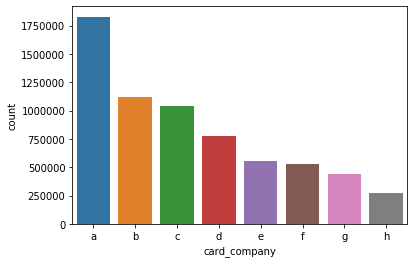

In [18]:
sns.countplot(df_train['card_company']
              , order = df_train['card_company'].value_counts().index)

### 카드사별 매출액 확인

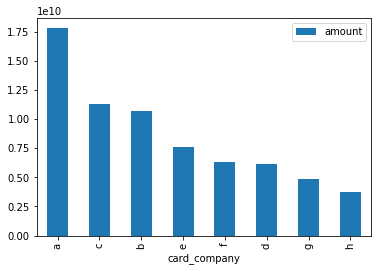

In [19]:
df_train[['card_company','amount']].groupby("card_company").sum().sort_values(by='amount', ascending=False).plot.bar()

### 카드사별 년도별 매출액 확인

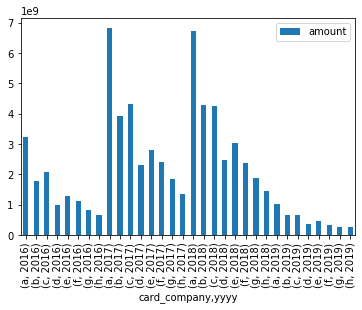

In [20]:
df_train[['card_company','amount', 'yyyy']].groupby(['card_company','yyyy']).sum().sort_values(by=['yyyy','card_company'], ascending=True).plot.bar()

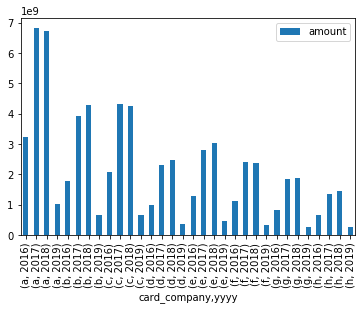

In [21]:
df_train[['card_company','amount', 'yyyy']].groupby(['card_company','yyyy']).sum().sort_values(by=['card_company','yyyy'], ascending=True).plot.bar()

글쎄.. 이것만 봐서는 모르겠다